# Init

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=20)
p_style = ["D","x","o","s","h","^","v"]
l_style = ["-","--",":","-.",(0, (7, 2, 3, 2))]
color = ["k","r","b","g","m","y","c","tab:gray"]

# bench_df = pd.read_csv('bench_intersection_results.csv')
bench_df = pd.read_csv('bench_intersection_A100_results.csv')
# bench_df = pd.read_csv('bench_intersection_P100_results.csv')

# Speedup

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


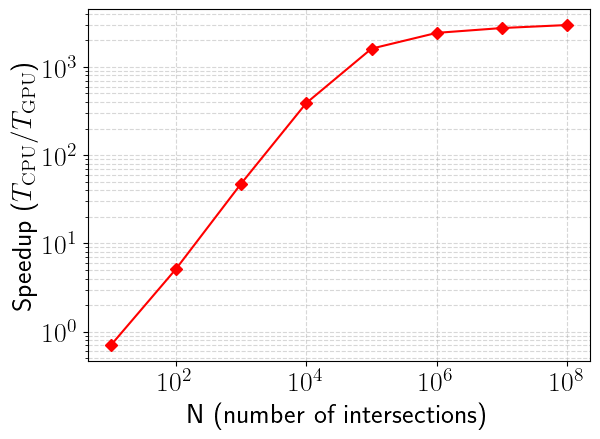

In [ ]:
fig_bench, ax_bench = plt.subplots()
# ax_bench.plot(bench_df['n'], bench_df['cpu_time_s'] / bench_df['gpu_total_s'],
ax_bench.plot(bench_df['n'], bench_df['speedup_cpu_over_gpu'], 
			  marker=p_style[0], linestyle=l_style[0], color=color[1])

ax_bench.set_xlabel('N (number of intersections)')
ax_bench.set_xscale('log')
ax_bench.set_yscale('log')
ax_bench.set_ylabel('Speedup ($T_{\\mathrm{CPU}}/T_{\\mathrm{GPU}}$)')
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.show()
fig_bench.savefig("speedup.eps", format="eps")
fig_bench.savefig("speedup.png", format="png")

# Total time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


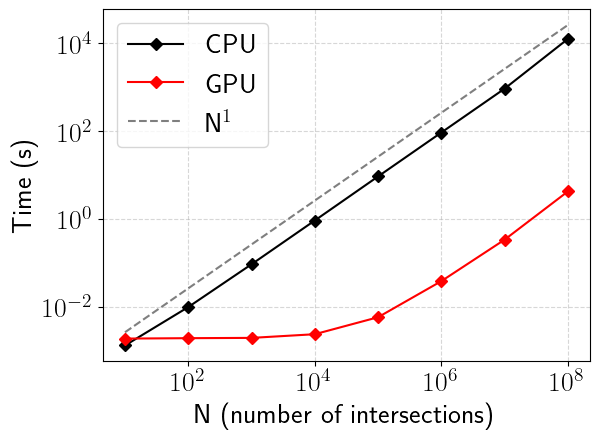

In [ ]:
fig_bench, ax_bench = plt.subplots()
ax_bench.plot(bench_df['n'], bench_df['cpu_time_s'],
              label='CPU',
			  marker=p_style[0], linestyle=l_style[0], color=color[0])
ax_bench.plot(bench_df['n'], bench_df['gpu_time_s'],
              label='GPU',
			  marker=p_style[0], linestyle=l_style[0], color=color[1])
ax_bench.plot(bench_df['n'], bench_df['n'] * (bench_df['cpu_time_s'][0]/bench_df['n'][0]*2),
              label='N$^1$',
			  marker=" ", linestyle=l_style[1], color=color[0], alpha=0.5)
# ax_bench.plot(bench_df['n'][:4], bench_df['n'][:4]**(1/32) * (bench_df['gpu_time_s'][0]/bench_df['n'][0]*2),
#               label='N$^{1/32}$',
# 			  marker=" ", linestyle=l_style[1], color=color[1], alpha=0.5)

ax_bench.set_xlabel('N (number of intersections)')
ax_bench.set_xscale('log')
ax_bench.set_yscale('log')
ax_bench.set_ylabel('Time (s)')
ax_bench.legend()
ax_bench.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.show()
fig_bench.savefig("time_scaling.eps", format="eps")
fig_bench.savefig("time_scaling.png", format="png")

# Breakdown

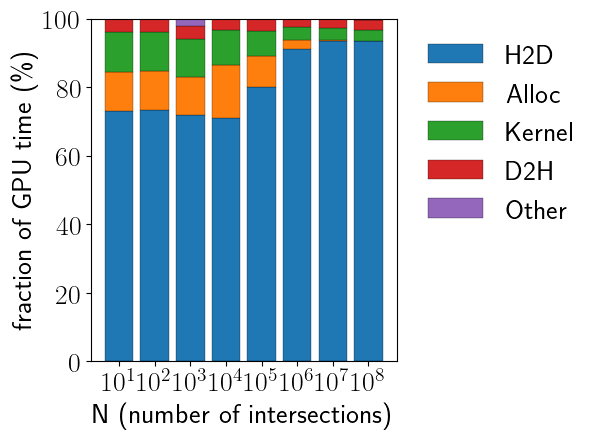

In [ ]:
# Components available in the CSV
components = []
components.append(('H2D', bench_df['gpu_h2d_s'].astype(float)))
components.append(('Alloc', bench_df['gpu_alloc_s'].astype(float)))
components.append(('Kernel', bench_df['gpu_kernel_ms'].astype(float) * 1e-3))
components.append(('D2H', bench_df['gpu_d2h_s'].astype(float)))
total_gpu = bench_df['gpu_total_s'].astype(float) # kernal + overhead
gpu_call_time = bench_df['gpu_time_s'].astype(float) # end-to-end time (includes host array creation)

sum_known = np.zeros(len(bench_df), dtype=float)
for _, s in components:
    sum_known += np.asarray(s, dtype=float)

# other_bound = gpu_call_time
other_bound = total_gpu
other = np.maximum(0.0, np.asarray(other_bound, dtype=float) - sum_known)
if np.nanmax(other) > 0:
    components.append(('Other', other))

# Build percent matrix (rows=components, cols=cases)
labels = [name for name, _ in components]
P = np.vstack([np.asarray(s, dtype=float) / np.asarray(other_bound, dtype=float) * 100.0 for _, s in components])

# Plot stacked percent bars (reference: profiler_plot.py style)
x = np.arange(len(bench_df))
fig, ax = plt.subplots()
bottom = np.zeros(len(bench_df), dtype=float)

# Color mapping: reuse your palette where possible
for i, lab in enumerate(labels):
    vals = P[i]
    ax.bar(x, vals, bottom=bottom, label=lab, edgecolor='black', linewidth=0.2)
    bottom += np.nan_to_num(vals, nan=0.0)

# Tick labels as powers of 10 (LaTeX)
n_vals = bench_df['n'].astype(float).to_numpy()
exps = np.rint(np.log10(n_vals)).astype(int)
n_labels = [rf'$10^{{{e}}}$' for e in exps]
ax.set_xticks(x, n_labels)
ax.set_xlabel('N (number of intersections)')
ax.set_ylabel(r'fraction of GPU time (\%)')
ax.set_ylim(0, 100)
# ax.grid(True, axis='y', linestyle='--', alpha=1.0)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', edgecolor='none')
fig.tight_layout()

fig.savefig('gpu_time_breakdown.png', dpi=200, bbox_inches='tight')